##### This model follows the same fine tuning as model 07, but with the model maximum input lengths increased again to allow for the encoding of more text data. This change seemed to increase model performance in model 07, so the goal is to see if continued max length increase continues this progress. In this model, a longer model training time with an early stopping callnack is also added, to allow for the possibility of increased model performance with longer training.

# Imports

In [2]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize 
import random
import matplotlib.pyplot as plt

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Read in data

In [5]:
data = load_dataset(
    'csv', data_files={
        'train':'./modeling_data/training_data.csv',
        'test':'./modeling_data/testing_data.csv',
        'validation':'./modeling_data/validation_data.csv'
        }
    )

Using custom data configuration default-74d066c3e8549d77


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Pre-process data for input to model
code from https://huggingface.co/course/chapter7/5?fw=tf

## Set up model tokenizer

In [6]:
model_checkpoint = 'sshleifer/distilbart-xsum-1-1'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

## Tokenize data

In [7]:
def preprocess_function(text_data):
  model_inputs = tokenizer(
      text_data['chapter_text'], max_length=1024, truncation=True)     

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        text_data['chapter_summary'], max_length=1024, truncation=True)   
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [8]:
tokenized_data = data.map(preprocess_function)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

# Fine tune model

## Set up model

In [9]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/317M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at sshleifer/distilbart-xsum-1-1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


## Final processing of data for input to model

### Remove non-encoded columns from tokenized_data

In [10]:
tokenized_data_features = tokenized_data.remove_columns(
    data['train'].column_names
)

### Set up data collator to dynmaically pad inputs and labels

In [11]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='tf')

### Use data collator to perform final processing on tokenized_data_features for input to model

In [12]:
tf_train = tokenized_data_features['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=1
)

tf_validation = tokenized_data_features['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

## Set up model hyperparamaters

In [13]:
num_train_epochs = 25
num_train_steps = len(tf_train) * num_train_epochs

optimizer, schedule = create_optimizer(
    init_lr=5.6e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

## Compile model

In [14]:
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


## Fit model

In [15]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [16]:
model_history = model.fit(tf_train, validation_data=tf_validation, callbacks=[early_stop], epochs=25)

Epoch 1/25
212/212 [==============================] - 33s 104ms/step - loss: 5.6605 - val_loss: 5.0368
Epoch 2/25
212/212 [==============================] - 21s 100ms/step - loss: 4.9062 - val_loss: 4.7995
Epoch 3/25
212/212 [==============================] - 21s 99ms/step - loss: 4.5677 - val_loss: 4.7188
Epoch 4/25
212/212 [==============================] - 21s 97ms/step - loss: 4.3060 - val_loss: 4.6443
Epoch 5/25
212/212 [==============================] - 21s 97ms/step - loss: 4.0981 - val_loss: 4.6253
Epoch 6/25
212/212 [==============================] - 20s 97ms/step - loss: 3.9074 - val_loss: 4.6363
Epoch 7/25
212/212 [==============================] - 21s 99ms/step - loss: 3.7354 - val_loss: 4.6410
Epoch 8/25
212/212 [==============================] - 21s 99ms/step - loss: 3.5838 - val_loss: 4.6479
Epoch 9/25
212/212 [==============================] - 21s 97ms/step - loss: 3.4460 - val_loss: 4.6688
Epoch 10/25
212/212 [==============================] - 21s 99ms/step - loss: 3.3

# Visualize model

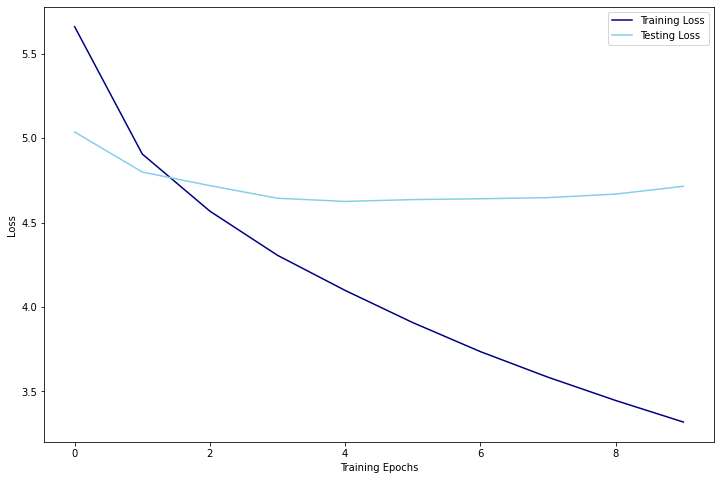

In [17]:
train_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(validation_loss, label='Testing Loss', color='skyblue')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend();

The loss for the validation data in the model is higher than the loss for the training data, indicating that the model is overfitting. The loss functions seem to be diverging to a greater degree in this model thna in model 6 or 7.

# Rouge scores for training data

In [18]:
train_labels = []
train_preds = []

for batch in tqdm(tf_train):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    train_preds.extend(decoded_preds)
    train_labels.extend(decoded_labels)


100%|██████████| 212/212 [31:26<00:00,  8.90s/it]


In [19]:
rouge = load_metric('rouge')

train_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(train_results.keys()):
  mid_scores = train_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

Downloading:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

rouge1
precision: 95.65217391304348
recall: 8.239700374531834
f-measure: 15.172413793103448
***************
rouge2
precision: 63.63636363636363
recall: 5.263157894736842
f-measure: 9.72222222222222
***************
rougeL
precision: 82.6086956521739
recall: 7.116104868913857
f-measure: 13.103448275862068
***************
rougeLsum
precision: 95.65217391304348
recall: 8.239700374531834
f-measure: 15.172413793103448
***************


# Rouge scores for test data

In [20]:
tf_test = tokenized_data_features['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

In [21]:
test_labels = []
test_preds = []

for batch in tqdm(tf_test):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    test_preds.extend(decoded_preds)
    test_labels.extend(decoded_labels)

100%|██████████| 59/59 [09:21<00:00,  9.52s/it]


In [22]:
rouge = load_metric('rouge')

test_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(test_results.keys()):
  mid_scores = test_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

rouge1
precision: 60.0
recall: 13.100436681222707
f-measure: 21.505376344086024
***************
rouge2
precision: 14.285714285714285
recall: 3.070175438596491
f-measure: 5.054151624548737
***************
rougeL
precision: 32.0
recall: 6.986899563318777
f-measure: 11.46953405017921
***************
rougeLsum
precision: 50.0
recall: 10.91703056768559
f-measure: 17.921146953405017
***************


# Example model-generated summaries

In [23]:
rand_indexes = []
for i in range(3):
  rand_indexes.append(random.randint(0,59))

In [24]:
print(rand_indexes)

[57, 20, 35]


In [25]:
#Reference summary example 1
print(test_labels[57])

Mr. Collins begins to ignore Elizabeth, and his attentions are transferred to Miss Lucas.
After breakfast, the girls walk to Meryton and meet Wickham, who tells Elizabeth that he was not at the ball because he did not want to be in the same room as Darcy for so long.
When they return home, a letter is delivered to Jane, which quite distresses her.
She tells Elizabeth that it is from Caroline Bingley, and that the entire party has left Netherfield for London, and that they do not intend to return again.
Later in the letter Caroline says that all are anxious to see Miss Darcy again, as Louisa (Mrs. Hurst) and she are hoping for a marriage between her and Bingley.
Jane is quite upset about this, as she had held hopes of marrying Bingley, and now she finds out that Bingley's sisters want him to marry another.
Elizabeth tries to convince Jane that Bingley is indeed in love with her, and that this other marriage is just something that the sisters are trying to devise.
Jane does not believe t

In [26]:
#Model summary example 1
print(test_preds[57])

Mr. Collins returns from Wickham and Bingley after their visit to Wickham.
When they arrive, he finds Wickham, Jane and Wickham discuss the situation.
Elizabeth is not invited to visit Wickham to visit him.
He tells Elizabeth that he will not return to Wick


In [27]:
#Reference summary example 2
print(test_labels[20])

begins by explaining how Jurgis is still young and optimistic, and talks lightly about work.
He is also naïve and has never lived in a city before.
He met Ona and her family in Lithuania and her father initially refused him permission to marry her.
Jurgis went back to see her a year later to ask again only to find her father had died and the family were now impoverished.
This family now consisted of Ona, Teta Elzbieta, her six children and Ona’s brother Jonas.
They all believed that coming to the United States would give them freedom and more opportunities.
Before they set off, and at the last moment, Marija also decides to join them.
When they arrive in the Packingtown district in Chicago, the smell of the stockyards greets them first.
They are almost penniless once they reach here after being taken advantage of in New York (as they are clearly immigrants and know no English).
They all stay at Aniele Jukniene’s home as she takes in lodgers.
This is already overcrowded and ‘unthinkably

In [28]:
#Model summary example 2
print(test_preds[20])

Jurgis insists that he will not go ahead with his father, who has died aged 66.
Analysis This causes him to be married to a young man.
When he returns to his room.
He is not ready to go back to his house, but he tells him that he would not


In [29]:
#Reference summary example 3
print(test_labels[35])

Ellen tells Catherine to be quiet, as Joseph is near and that means Heathcliff will be coming.
Catherine is worried that Heathcliff may have heard her and says that she will never forsake Heathcliff.
She would not marry Edgar if it meant that she and Heathcliff would be separated.
She thinks that if she married Heathcliff they would be beggars, and if she marries Linton, she can help Heathcliff to rise and get him away from her brother.
When Joseph comes in looking for Heathcliff, Ellen calls for him outside but gets no answer.
She then tells Catherine that he had heard some of what she said, and she gets frightened.
Catherine runs outside to look for Heathcliff, and finally comes back, saying she will not go upstairs until she gets to talk to him.
She paces the floor, and they all wait, and Catherine stays outside crying when it starts to rain.
At midnight, the storm comes, and the wind is violent.
Ellen tries to talk Catherine into taking off her wet things and going to bed, but she 

In [30]:
#Model summary example 3
print(test_preds[35])

: Novel : 2 ›  In this chapter, Hareton and Hareton were killed by a knife attack on a wall near Heathcliff, and he stabbed to death in a wall that killed him.
He is madman, and that he will never be able to kill him, and


# Evaluation of model

Based on rouge scores, this model performed better than the baseline and previous finetuned models. The model-generated summaries have similar readability/logic to the previous model.